# STOCK PRICE PREDICTION OF AMAZON DATA USING GRU MODEL

In [ ]:
#Import libraries

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import random
import string
import pandas as pd 
from google.colab import drive
import math, time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
from sklearn.model_selection import train_test_split


In [ ]:
drive.mount('/content/drive')
!ls '/content/drive/My Drive/DeepLearning_2022/FinalProject/Data/'
path = '/content/drive/My Drive/DeepLearning_2022/FinalProject/Data/'
path_results = '/content/drive/My Drive/DeepLearning_2022/FinalProject/Results/'


Mounted at /content/drive
AMAZON.csv  DownloadData.ipynb	GOOGLE.csv


## LOAD AND VISUALIZE DATA

In [ ]:
#Read amazon dataset 
raw_data = pd.read_csv(path+'AMAZON.csv',parse_dates=True, index_col=0)
raw_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,6.8125,6.8305,6.6570,6.6950,6.6950,151998000
2010-01-05,6.6715,6.7740,6.5905,6.7345,6.7345,177038000
2010-01-06,6.7300,6.7365,6.5825,6.6125,6.6125,143576000
2010-01-07,6.6005,6.6160,6.4400,6.5000,6.5000,220604000
2010-01-08,6.5280,6.6840,6.4515,6.6760,6.6760,196610000


In [ ]:
raw_data.info() #not null data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2516 non-null   float64
 1   High       2516 non-null   float64
 2   Low        2516 non-null   float64
 3   Close      2516 non-null   float64
 4   Adj Close  2516 non-null   float64
 5   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


We collected the data for 10 years (from 01 January 2012 to 01 January 2022) and have 2517 instances in each dataset. We can observe that there is non-null values in our dataset and the most of the feature are float except Volume that is an integer and the date that is an object. We will explain the meaining of the features of the dataset:


*   Date: It is the date of the observation
*   Open: Raw stock values when the market opened.
*   High: Highest stock value in that date.
*   Low: Lowest stock value in that date.
*   Close: Raw stock values when the market closed.
*   Adj Close: Estimated stock values after the market closes.
*   Volume: Number of shares traded. 

We are going to work with the stock values when the market closed, the feature *Close*.


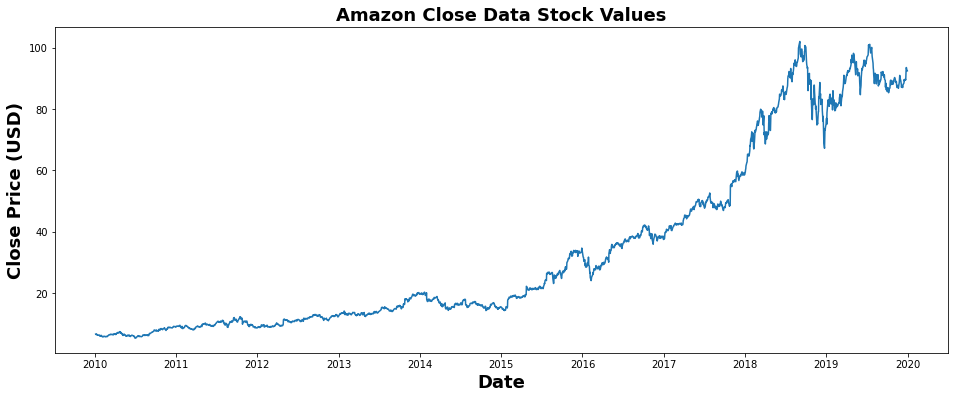

In [ ]:
#Visualize the close price
plt.figure(figsize = (16,6))
plt.title('Amazon Close Data Stock Values', fontsize = 18,fontweight = "bold")
plt.plot(raw_data['Close'])
plt.xlabel("Date" , fontsize = 18,fontweight = "bold")
plt.ylabel("Close Price (USD)", fontsize = 18,fontweight = "bold")

plt.show()

<function matplotlib.pyplot.show>

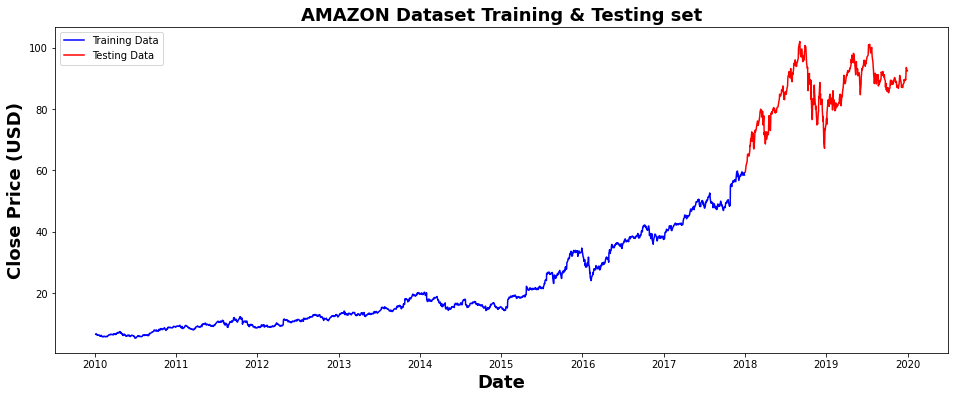

In [ ]:
#Visualize the train and test set 
traininig_size = round(raw_data.shape[0]*0.8)
training = raw_data.iloc[:traininig_size,:]
testing = raw_data.iloc[traininig_size:,:]

plt.figure(figsize = (16,6))
ax = plt.axes()
plt.title('AMAZON Dataset Training & Testing set', fontsize = 18,fontweight = "bold")
plt.xlabel('Date' , fontsize = 18,fontweight = "bold")
plt.ylabel('Close Price (USD)', fontsize = 18,fontweight = "bold")
plt.plot(training['Close'], 'blue', label='Training Data')
plt.plot(testing['Close'], 'red', label='Testing Data')
plt.legend()
plt.show

#plt.xticks(np.arange(0,1857, 300), df['Date'][0:1857:300])
plt.legend()
plt.show

## NORMALIZE AND SPLIT DATA INTO TRAIN AND TEST DATASET

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
# we work only with close values
df_amzn = raw_data.filter(items=['Close'])

#Normalize data between -1 and 1 
df_amzn["Close"]= scaler.fit_transform(df_amzn["Close"].values.reshape(-1,1))
df_amzn

,Close
Date,
2010-01-04,-0.973805
2010-01-05,-0.972987
2010-01-06,-0.975514
2010-01-07,-0.977845
2010-01-08,-0.974199
...,...
2019-12-24,0.740743
2019-12-26,0.823150
2019-12-27,0.824217


In [ ]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    x = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        x.append(data_raw[index : index + look_back])
    
    x = np.array(x)  

    test_set_size = int(np.round(0.2*x.shape[0]))
    train_set_size = x.shape[0] - (test_set_size)

    #Create new data set
    x_train = x[:train_set_size,:-1]
    y_train = x[:train_set_size,-1]

    x_test = x[train_set_size:,:-1]
    y_test = x[train_set_size:,-1]

    
    return [x_train, y_train, x_test, y_test]


look_back = 30 #Choose sequence length


x_train, y_train, x_test, y_test = load_data(df_amzn, look_back)


print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1989, 29, 1)
y_train.shape =  (1989, 1)
x_test.shape =  (497, 29, 1)
y_test.shape =  (497, 1)


In [ ]:
#Convert dataset from numpy to tensor 
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


## Create the GRU model 

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out_gru, (hn) = self.gru(x, h0.detach())
        out = self.fc(out_gru[:,-1,:])
        return out
    

We define the model, loss function and hyperparameters

In [ ]:
#parameters
input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 1
num_epochs =100

model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = torch.nn.MSELoss()  #Mean Square Error loss function

optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #Adam optimizer

## Train and Testing

Epoch  0 MSE:  0.6696637868881226
Epoch  1 MSE:  0.15397675335407257
Epoch  2 MSE:  0.1898721158504486
Epoch  3 MSE:  0.05916015803813934
Epoch  4 MSE:  0.07611910253763199
Epoch  5 MSE:  0.09728742390871048
Epoch  6 MSE:  0.07440849393606186
Epoch  7 MSE:  0.03566748648881912
Epoch  8 MSE:  0.027233008295297623
Epoch  9 MSE:  0.053828392177820206
Epoch  10 MSE:  0.034014925360679626
Epoch  11 MSE:  0.008745204657316208
Epoch  12 MSE:  0.01600499078631401
Epoch  13 MSE:  0.027678171172738075
Epoch  14 MSE:  0.019214602187275887
Epoch  15 MSE:  0.0022076650056988
Epoch  16 MSE:  0.007162683643400669
Epoch  17 MSE:  0.020192984491586685
Epoch  18 MSE:  0.00798525009304285
Epoch  19 MSE:  0.000630080932751298
Epoch  20 MSE:  0.006563681643456221
Epoch  21 MSE:  0.010684656910598278
Epoch  22 MSE:  0.007238968275487423
Epoch  23 MSE:  0.0018493194365873933
Epoch  24 MSE:  0.0015818411484360695
Epoch  25 MSE:  0.005729853641241789
Epoch  26 MSE:  0.006939164362847805
Epoch  27 MSE:  0.00347

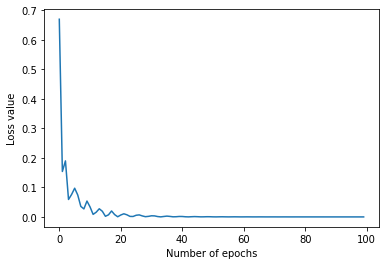

In [ ]:
#Trainig the model 
loss_gru = []
model.train() #active train mode
for iter in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", iter, "MSE: ", loss.item())

    loss_gru.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(loss_gru)
plt.xlabel("Number of epochs")
plt.ylabel("Loss value")
plt.show()

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

Text(0, 0.5, 'Close Price (USD)')

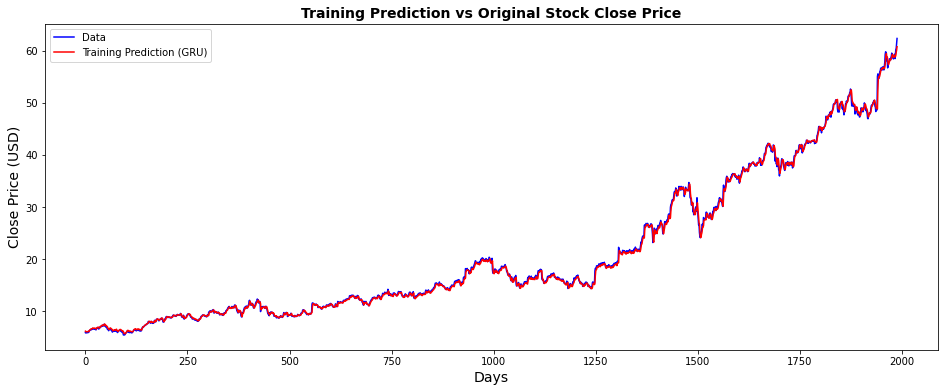

In [ ]:
#Visualize the training predictions

predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

plt.figure(figsize = (16,6))

ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='red')
ax.set_title('Training Prediction vs Original Stock Close Price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Close Price (USD)", size = 14)





In [ ]:
#Testing the model 

# make predictions
model.eval()
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

Text(0, 0.5, 'Close Price (USD)')

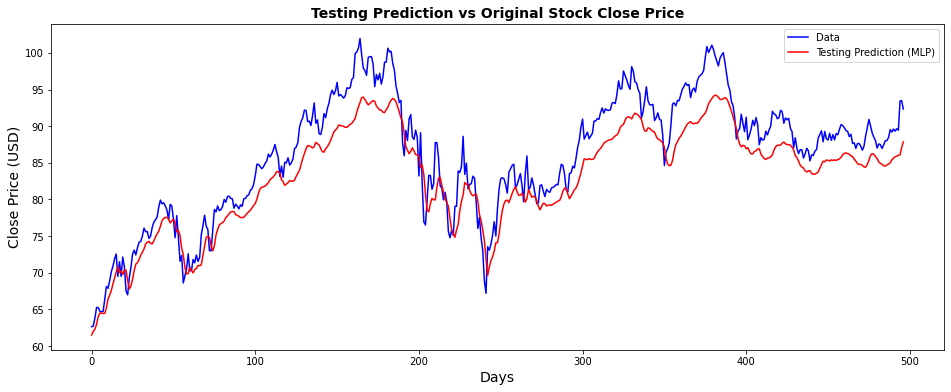

In [ ]:
#Visualize the testing predictions
original =  pd.DataFrame(y_test)
predict =  pd.DataFrame(y_test_pred)

plt.figure(figsize = (16,6))

ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Testing Prediction (MLP)", color='red')
ax.set_title('Testing Prediction vs Original Stock Close Price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Close Price (USD)", size = 14)

## VISUALIZE RESULTS

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_amzn)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred)+look_back, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_amzn)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+look_back-1:len(df_amzn)-1, :] = y_test_pred

original = scaler.inverse_transform(df_amzn['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

loss_gru.append(trainScore)
loss_gru.append(testScore)

Train Score: 0.47 RMSE
Test Score: 3.78 RMSE


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value',
                    )))
fig.update_layout(
    xaxis=dict(
        title_text='Days',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='black',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='black',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
    ),
    showlegend=True,
    template = 'plotly_white'

)

annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU) AMAZON',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='black'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()


In [ ]:
result_GRU_AMZN= result.set_index(raw_data.index)
result_GRU_AMZN.to_csv(path_results+'result_GRU_AMZN.csv')